[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ThomasAlbin/Astroniz-YT-Tutorials/blob/main/[ML1]-Asteroid-Spectra/14_dl_autoencoder_gmm_check.ipynb)

# Step 14: GMM - The right way?

Last time we finialized our project, using GMM to cluster the laten space of the Autoencoder's result.

Some would say that this is the final milestone of an un-supervised model. But wait! Do Gaussian describe our data really that good? How can we be sure? Let jump to [cell 15](#SessionStart), to get a FINAL answer!

(I promise, this is the very last session, no tricks!)

In [1]:
# Import standard libraries
import os

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Scikit-Learn stuff
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

# Keras
import tensorflow.keras as keras
import tensorflow as tf

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

In [2]:
# Set seeds to create reproducible experiments
np.random.seed(1)
tf.random.set_seed(1)

In [3]:
# Let's mount the Google Drive, where we store files and models (if applicable, otherwise work
# locally)
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""
    
# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())
asteroids_y_bus = np.array(asteroids_df["Bus_Class"].to_list())

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## ShuffleSplit

Although we do not conduct a classification ML experiment, we still consider the distribution of the classes to train our network properly.

In [4]:
# In this example we create a single test-training split with a ratio of 0.8 / 0.2
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]
    y_train_bus, y_test_bus = asteroids_y_bus[train_index], asteroids_y_bus[test_index]

## Scaling

This time we are creating a scikit-learn scaler for our spectra data. The model's prediction signals need to be transformed inversely later on to display them correctly.

In [5]:
# Import the preprocessing module
from sklearn import preprocessing

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
scaler = preprocessing.StandardScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)

# Scale the testing data ...
X_test_scaled = scaler.transform(X_test)

# And expanding the dimensionality for our ConvNet-based Autoencoder
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

## Building the Autoencoder

Now we create a ConvNet Autoencoder. Note that we are not using Keras-Tuner this time. Feel free to apply Keras-Tuner as a small coding exercise.

In [6]:
# Get the number of inputs
n_inputs = asteroids_X.shape[1]

# Let's create an autoencoder with a 2-D latent space
n_bottleneck = 5

def create_model():
    
    # Input layer, this time without a normalisation layer
    input_layer = keras.Input(shape=(n_inputs, 1))
    
    # Conv Layers (we won't be using maxpooling, since the dimensionaliy is 49 and we do not
    # alter the data in our example
    hidden_layer = keras.layers.Conv1D(filters=16,
                                       activation="relu",
                                       kernel_size=3, padding="same")(input_layer)
    hidden_layer = keras.layers.Conv1D(filters=32,
                                       activation="relu",
                                       kernel_size=3, padding="same")(hidden_layer)
    
    # Encoder ("Bottleneck" of the Autoencoder)
    bottleneck_lay = keras.layers.Flatten()(hidden_layer)
    bottleneck_lay = keras.layers.Dense(n_bottleneck)(bottleneck_lay)

    # The original shape must be restored and reshaped accordingly
    reset_lay = keras.layers.Dense(49*32)(bottleneck_lay)
    reshape_lay = keras.layers.Reshape((49, 32))(reset_lay)

    # First and second hidden decoder layers
    hidden_layer = keras.layers.Conv1DTranspose(filters=32,
                                                kernel_size=3,
                                                strides=1,
                                                activation="relu",
                                                padding="same")(reshape_lay)
    hidden_layer = keras.layers.Conv1DTranspose(filters=16,
                                                kernel_size=3,
                                                strides=1,
                                                activation="relu",
                                                padding="same")(hidden_layer)

    # Ouput layer (same size as input layer)
    output_layer = keras.layers.Conv1D(1, 1, padding="same")(hidden_layer)

    # Create model
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    # Create encoder model
    encoder_model = keras.models.Model(inputs=input_layer, outputs=bottleneck_lay)
    
    # We return the model and the encoder
    return model, encoder_model

model, encoder_model = create_model()

# Compile the model and use a regression loss function
model.compile(optimizer='adam', loss='mse')

# Show the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 49, 16)            64        
                                                                 
 conv1d_1 (Conv1D)           (None, 49, 32)            1568      
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 5)                 7845      
                                                                 
 dense_1 (Dense)             (None, 1568)              9408      
                                                                 
 reshape (Reshape)           (None, 49, 32)            0     

In [7]:
# Train the model
end_epoch = 500
batch_size = 32

# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_scaled, X_train_scaled,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0,
                    validation_split=0.25,
                    callbacks=[es_callback])

## The loss function

Let's show the loss of the training and test data. As you can see, the minimum-plateau is reached quite fast. The test data performs slightly better than the training data, since the loss results for the training data are based on an average of the batch size. The test results are based on all data.

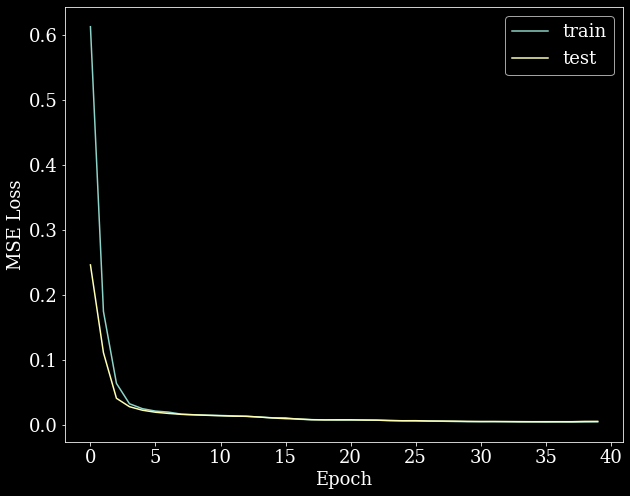

In [8]:
# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# plot the training and validation loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

# Add legend and labels
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

# ... aaaaand plot!
plt.show()

## Signal Reconstruction

... can be done by using the entire model to predict the output spectra. The following code snippet takes a signal (change the index value in the first line to use any other signal) and predicts the Autoencoder based spectrum.

As one can see, the results are "quite ok" but not perfect. The shape of the spectra can be reproduced. However, the signals are quite noisy.

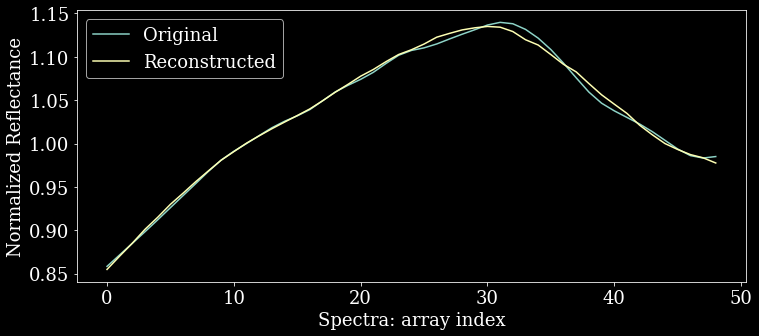

In [9]:
# Which index shall be displayed?
index_val = 5

# Original signal
org_signal = scaler.inverse_transform(X_train_scaled[index_val].reshape(1, -1))[0]
# Reconstructed signal
rec_signal = scaler.inverse_transform(model.predict(X_train_scaled)[index_val].reshape(1, -1))[0]

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# plot the training and reconstructed data
plt.figure(figsize=(12,5))
plt.plot(org_signal, label='Original')
plt.plot(rec_signal, label='Reconstructed')

# Add legend and labels
plt.legend()
plt.xlabel("Spectra: array index")
plt.ylabel("Normalized Reflectance")

# ... aaaaand plot!
plt.show()

In [10]:
# Create dataframe that contains the encoder values and the corresponding class to see whether the
# autoencoder values cluster in a way

# Encode the spectra
X_train_encoded = encoder_model.predict(X_train_scaled)
X_test_encoded = encoder_model.predict(X_test_scaled)

# Merge the data
X_encoded = np.vstack((X_train_encoded, X_test_encoded))

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the encoded data to fit
# the scaler
enc_scaler = preprocessing.StandardScaler().fit(X_encoded)

# Transform now the encoded data (later used for our scikit-learn method)
X_encoded_scaled = enc_scaler.transform(X_encoded)

# Merge the classes
y_main = np.hstack((y_train, y_test))
y_bus = np.hstack((y_train_bus, y_test_bus))

# Create a column names array for the encoded space
encoder_space = [f"enc{enc_nr+1}" for enc_nr in range(n_bottleneck)]
encoder_space_cols = encoder_space.copy()
encoder_space.extend(["Main_Group", "Bus_Class"])

# Create the dataframe
encoded_df = pd.DataFrame(np.hstack((X_encoded_scaled,
                                     y_main[np.newaxis].transpose(),
                                     y_bus[np.newaxis].transpose())),
                          columns=encoder_space)

# Change the dtype to float
encoded_df.loc[:, encoder_space[:-2]] = encoded_df.loc[:, encoder_space[:-2]].astype(float)

## Gaussian Mixture Model
With the encoded values we will now conduct a clustering experiment using Gaussian Mixture Models (GMMs). The multi-dimensional data will be used to fit a varying number of Gaussians.

The question is: How many Gaussians are needed to fit the data... "properly"?

For this, we will fit an increasing number of Gaussians and compute the corresponding, so-called *Bayesion Information Criterion* (BIC). This values ia a quantified version of Occam's Razor: more parameters may describe the data better, but more parameters will be punished. Goal: finding the perfect balance between "explainability" and "overfitting".

In [11]:
import sklearn.mixture
import tqdm

# Result dataframe that will contain the number of Gaussian components, the Bayesion Information
# Criterion (BIC) and the model itself
gmm_results_df = pd.DataFrame([], columns=["Nr_Comp", "BIC", "Model"])

# We iterate through a number of "component guesses"
max_gauss = 15
for index, gauss_components in tqdm.tqdm(enumerate(np.arange(1, max_gauss+1, 1))):

    # Create and fit a temporary Gaussian Mixture Model
    temp_gmm = sklearn.mixture.GaussianMixture(n_components=gauss_components,
                                               covariance_type="full")
    temp_gmm.fit(X_encoded_scaled)

    # Store the number of components, the BIC and the model
    gmm_results_df.loc[index, "Nr_Comp"] = gauss_components
    gmm_results_df.loc[index, "BIC"] = temp_gmm.bic(X_encoded_scaled)
    gmm_results_df.loc[index, "Model"] = temp_gmm

15it [00:02,  5.56it/s]


(1.0, 15.0)

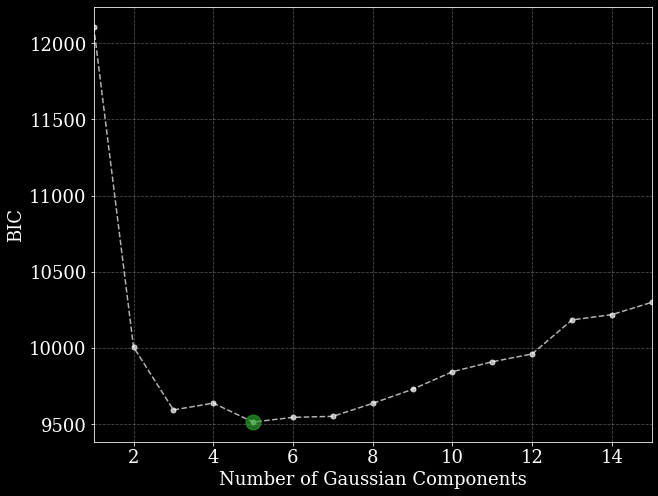

In [12]:
# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# Plotting the BIC vs. the number of components
plt.figure(figsize=(10, 8))

plt.plot(gmm_results_df["Nr_Comp"],
         gmm_results_df["BIC"],
         linestyle="dashed",
         marker="o",
         markersize=5,
         color="w",
         alpha=0.7)

# Color the minimum value
gmm_results_best = gmm_results_df.loc[gmm_results_df["BIC"] == gmm_results_df["BIC"].min()]
plt.plot(gmm_results_best["Nr_Comp"],
         gmm_results_best["BIC"],
         marker="o",
         markersize=15,
         color="tab:green",
         alpha=0.7)

# Some formatting
plt.xlabel("Number of Gaussian Components")
plt.ylabel("BIC")
plt.grid(linestyle="dashed", alpha=0.3)
plt.xlim(1, max_gauss)

In [13]:
# Let's take the best GMM!
best_gmm = gmm_results_best["Model"].iloc[0]

# Create a new dataframe column that labels the spectra based on our GMM model:
encoded_df.loc[:, "GMM_Class"] = best_gmm.predict(encoded_df[encoder_space_cols].values)

encoded_df

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class,GMM_Class
0,1.015225,-0.510762,-1.672957,0.351253,1.68429,C,B,1
1,-0.896699,-0.183062,0.714723,0.247081,-0.430078,S,S,0
2,1.308429,0.152425,-1.328945,0.802201,1.13381,C,Ch,1
3,0.959538,0.59086,-1.089651,0.989794,0.936856,C,C,1
4,-1.765675,1.370504,0.509956,1.300437,0.873746,Other,V,4
...,...,...,...,...,...,...,...,...
1334,-1.149735,-2.769146,1.145128,-1.528896,-0.929604,S,Sl,2
1335,1.170942,0.51547,-1.228624,0.915299,1.216895,C,Ch,1
1336,0.700203,0.17443,-0.835018,0.711023,0.321864,X,Xe,3
1337,0.579327,0.242054,-1.22332,-0.030623,1.2995,C,Cb,1


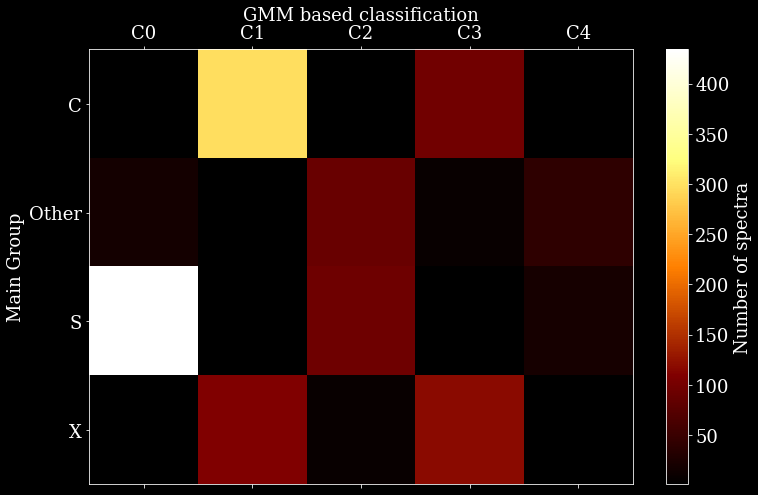

In [14]:
# Groupby the Main group and the GMM classification
encoded_grouped_df = pd.crosstab(index=encoded_df["Main_Group"],
                                 columns=encoded_df["GMM_Class"],
                                 values=encoded_df["enc1"],
                                 aggfunc="count")

# Extract data, column and index names for plotting purposes
encoded_grouped_values = encoded_grouped_df.values
encoded_grouped_main = encoded_grouped_df.index.values
encoded_grouped_gmm = [f"C{k}" for k in encoded_grouped_df.columns.values]


# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# Create a matrix-like plot of the results
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
cax = ax.matshow(encoded_grouped_values, cmap="afmhot")
fig.colorbar(cax, label="Number of spectra", fraction=0.05)

# Some plotting settings
ax.set_xticks(range(len(encoded_grouped_gmm)))
ax.set_yticks(range(len(encoded_grouped_main)))
ax.set_xticklabels(encoded_grouped_gmm)
ax.set_yticklabels(encoded_grouped_main)

ax.set_xlabel("GMM based classification")
ax.set_ylabel("Main Group")
ax.xaxis.set_label_position('top') 

## GMM Check
<a id='SessionStart'></a>
Let's answer the question: are GMM the perfect choice? Let's focus on the S-types!

In [15]:
# Consider only the S-types and let's check the corresponding GMM class
encoded_main_s_df = encoded_df.loc[encoded_df["Main_Group"] == "S"].copy()

encoded_main_s_df.groupby("GMM_Class").count()

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class
GMM_Class,,,,,,,
0,434,434,434,434,434,434,434
2,95,95,95,95,95,95,95
4,20,20,20,20,20,20,20


In [16]:
# We compute now the prediction probability of each laten vector
encoded_grouped_gmm_prob = [f"C{k}Prob" for k in encoded_grouped_df.columns.values]

encoded_main_s_df.loc[:, encoded_grouped_gmm_prob] = \
    best_gmm.predict_proba(encoded_main_s_df[encoder_space_cols].values)

encoded_main_s_df

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class,GMM_Class,C0Prob,C1Prob,C2Prob,C3Prob,C4Prob
1,-0.896699,-0.183062,0.714723,0.247081,-0.430078,S,S,0,0.988199,3.281819e-23,0.008302,9.757749e-14,0.003498
5,-0.318427,0.484425,0.158963,0.715792,-0.069422,S,Sk,0,0.990951,3.275015e-11,0.004376,2.464838e-06,0.004671
7,-0.940662,-0.659272,0.897858,-0.371238,-0.999409,S,S,0,0.991282,7.386105e-23,0.006734,2.329477e-14,0.001983
8,-0.72639,0.768703,0.763036,0.460452,0.083677,S,Sq,0,0.937026,4.615007e-21,0.055293,7.375897e-10,0.007681
11,-0.361989,-0.23895,0.575249,-0.410375,-0.48923,S,S,0,0.951259,1.412424e-12,0.048424,1.218299e-06,0.000316
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325,-0.882644,-1.392311,0.970334,-0.936457,-1.099629,S,S,0,0.912377,5.652044e-25,0.087369,2.205542e-14,0.000254
1327,-1.342581,-0.024286,1.450064,-0.417358,-0.621303,S,S,0,0.798174,3.117195e-37,0.195723,4.347357e-19,0.006103
1331,-0.795647,-0.665792,1.284119,-0.762325,-0.881155,S,S,0,0.846571,8.170730e-30,0.153226,8.326017e-13,0.000203
1332,-0.787042,-0.230206,0.456551,-0.268303,-0.508947,S,S,0,0.989152,3.023699e-16,0.008077,5.094074e-11,0.002770


Text(0, 0.5, 'Number of spectra')

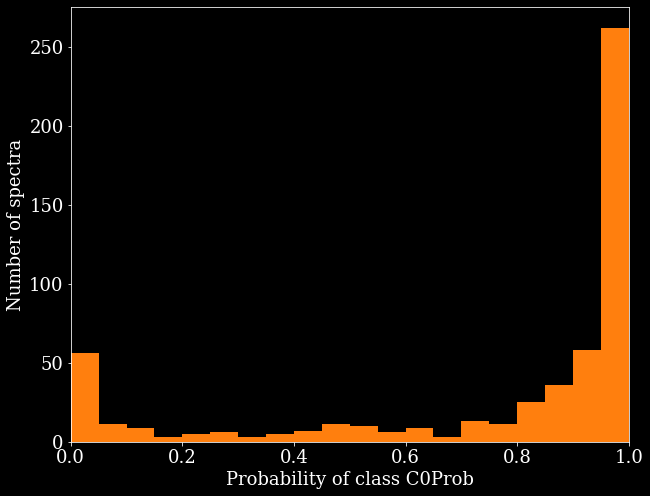

In [17]:
# In our case we use the very first Gaussian (please note: this is hardcoded and should be
# reproducible, considering the set seeds. If you change the seeds, check in cell 15 the "most
# precent" GMM Class and change the name here accordingly
gmm_cl = "C0Prob"

# Let's plot the probability distribution
plt.figure(figsize=(10, 8))

plt.hist(encoded_main_s_df[gmm_cl], bins=np.arange(0, 1.1, 0.05), color="tab:orange")

plt.xlim(0, 1)

plt.xlabel(f"Probability of class {gmm_cl}")
plt.ylabel("Number of spectra")

# In our case, over 250 spectra are assigned to Cluster 0 with a probability >= 95 %

In [19]:
# ... so we check only the spectra that are most likely linked to this Gaussian
encoded_main_s_df = encoded_main_s_df.loc[encoded_main_s_df[gmm_cl] >= 0.95]

encoded_main_s_df

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class,GMM_Class,C0Prob,C1Prob,C2Prob,C3Prob,C4Prob
1,-0.896699,-0.183062,0.714723,0.247081,-0.430078,S,S,0,0.988199,3.281819e-23,0.008302,9.757749e-14,0.003498
5,-0.318427,0.484425,0.158963,0.715792,-0.069422,S,Sk,0,0.990951,3.275015e-11,0.004376,2.464838e-06,0.004671
7,-0.940662,-0.659272,0.897858,-0.371238,-0.999409,S,S,0,0.991282,7.386105e-23,0.006734,2.329477e-14,0.001983
11,-0.361989,-0.23895,0.575249,-0.410375,-0.48923,S,S,0,0.951259,1.412424e-12,0.048424,1.218299e-06,0.000316
13,-0.855369,0.428129,0.718303,0.167372,-0.648287,S,S,0,0.980254,3.707006e-19,0.002490,1.624790e-11,0.017255
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296,-0.275377,-0.087008,0.334069,0.163309,-0.578684,S,S,0,0.990426,3.158331e-10,0.007164,3.013810e-06,0.002406
1305,-0.140904,1.055924,0.070341,1.046595,0.135451,S,Sq,0,0.986592,4.449715e-09,0.004710,2.292163e-04,0.008469
1307,-0.218354,-0.487407,0.318256,-0.718157,-1.07266,S,S,0,0.964720,1.643242e-07,0.031365,3.903683e-05,0.003876
1310,-0.864936,-0.30266,0.796995,-0.268704,-0.638847,S,S,0,0.990646,8.856299e-21,0.008419,7.024398e-13,0.000935


In [21]:
# We'll use pingouin to ...
!pip install pingouin
import pingouin

In [ ]:
# ... compute whether the data describe a Gaussian distribution
encoded_main_s = np.array(encoded_main_s_df[encoder_space_cols].values, dtype="float64")
pingouin.multivariate_normality(encoded_main_s)

HZResults(hz=1.123687714421913, pval=0.0008512005349649815, normal=False)

# Summary & Outlook

Well, be aware what kind of clustering algorithm you choose! Sometimes, pitfalls are not always apparent, especially if the data is multi-dimensional. [scikit-learn](https://scikit-learn.org/stable/modules/clustering.html) provides a nice overview of other clustering algorithms. Try it out!

We conclude now our asteroid spectra part. Of course the journey is not finished and one could extend this project e.g., by considering the orbital elements, detection bias effects and other topics. But that's something for the future, maybe.

Our next project will focus on Near-Earth Objects (NEOs); and we'll answer the question how we could optimize our survey strategy to optimize the search for more NEOs! Stay tuned!